<a href="https://colab.research.google.com/github/KirkDCO/HandsOnML_Exercises/blob/main/Ch17_Q09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train, X_valid = X_train_full[5000:]/255, X_train_full[:5000]/255
y_train, y_valid = y_train_full[5000:], y_train_full[:5000]

X_test = X_test/255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test = keras.utils.to_categorical(y_test, 10) 

In [ ]:
encoder = keras.models.Sequential([
            keras.layers.GaussianNoise(0.1, input_shape = [28, 28, 1]),
            keras.layers.Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Flatten(),
            keras.layers.Dense(128)
])

encoder.summary()

decoder = keras.models.Sequential([
            keras.layers.Dense(14 * 14 * 32, activation = "relu", input_shape = [128]),
            keras.layers.Reshape([14, 14, 32]),
            keras.layers.Conv2DTranspose(filters = 1, kernel_size = 3, strides = 2,
                                         padding = "same", activation = "sigmoid")
])

decoder.summary()

dae = keras.models.Sequential([encoder, decoder])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 28, 28, 1)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               802944    
                                                                 
Total params: 803,264
Trainable params: 803,264
Non-trai

In [ ]:
# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

# compile and run
dae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
            metrics=["mse"])
history = dae.fit(X_train, X_train, epochs = 10,
                  validation_data = (X_valid, X_valid),
                  callbacks = [lr_scheduler, early_stopping_cb])

Epoch 1/10
1719/1719 [==============================] - 21s 11ms/step - loss: 0.2942 - mse: 0.0174 - val_loss: 0.2810 - val_mse: 0.0136 - lr: 0.0010
Epoch 2/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2673 - mse: 0.0083 - val_loss: 0.2771 - val_mse: 0.0120 - lr: 7.9433e-04
Epoch 3/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2626 - mse: 0.0067 - val_loss: 0.2661 - val_mse: 0.0085 - lr: 6.3096e-04
Epoch 4/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.2604 - mse: 0.0060 - val_loss: 0.2616 - val_mse: 0.0071 - lr: 5.0119e-04
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2591 - mse: 0.0056 - val_loss: 0.2598 - val_mse: 0.0065 - lr: 3.9811e-04
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2583 - mse: 0.0053 - val_loss: 0.2605 - val_mse: 0.0066 - lr: 3.1623e-04
Epoch 7/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2577 -

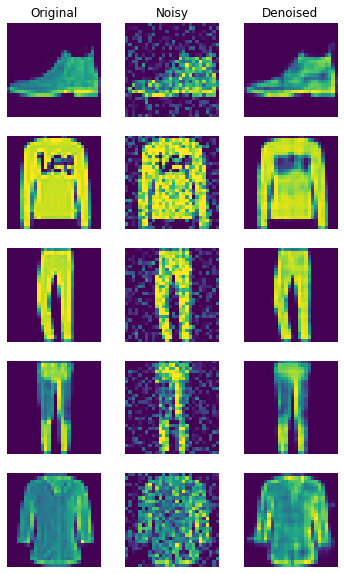

In [ ]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 28, 28) * 0.2
new_images_denoised = dae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index] * 255)
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index][..., -1])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

In [ ]:
X_train500_enc = encoder.predict(X_train[:500])
X_valid_enc = encoder.predict(X_valid)
X_test_enc = encoder.predict(X_test)

dae_model = keras.models.Sequential([
              keras.layers.Dense(64, activation = 'relu', input_shape = [128]),
              keras.layers.BatchNormalization(),
              keras.layers.Dropout(0.25),
              keras.layers.Dense(32, activation = 'relu'),
              keras.layers.BatchNormalization(),
              keras.layers.Dropout(0.25),
              keras.layers.Dense(10, activation = 'softmax')
])

dae_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_6 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 32)               

In [ ]:
# compile and run
dae_model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.Nadam(),
                  metrics = ["accuracy"])
history = dae_model.fit(X_train500_enc, y_train[:500], epochs = 100,
                        validation_data = (X_valid_enc, y_valid),
                        callbacks = [lr_scheduler, early_stopping_cb])
dae_model.evaluate(X_test_enc, y_test)

Epoch 1/100
16/16 [==============================] - 2s 48ms/step - loss: 1.2232 - accuracy: 0.6080 - val_loss: 1.0073 - val_accuracy: 0.6934 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 1s 37ms/step - loss: 1.1098 - accuracy: 0.6380 - val_loss: 0.9387 - val_accuracy: 0.7082 - lr: 7.9433e-04
Epoch 3/100
16/16 [==============================] - 1s 50ms/step - loss: 1.0108 - accuracy: 0.6760 - val_loss: 0.8935 - val_accuracy: 0.7256 - lr: 6.3096e-04
Epoch 4/100
16/16 [==============================] - 1s 37ms/step - loss: 0.9608 - accuracy: 0.7000 - val_loss: 0.8604 - val_accuracy: 0.7360 - lr: 5.0119e-04
Epoch 5/100
16/16 [==============================] - 1s 35ms/step - loss: 0.9785 - accuracy: 0.6940 - val_loss: 0.8402 - val_accuracy: 0.7402 - lr: 3.9811e-04
Epoch 6/100
16/16 [==============================] - 1s 50ms/step - loss: 0.8745 - accuracy: 0.7240 - val_loss: 0.8253 - val_accuracy: 0.7442 - lr: 3.1623e-04
Epoch 7/100
16/16 [==============================]

[0.8085425496101379, 0.746999979019165]

In [ ]:
basicCNN = keras.models.Sequential([
           keras.layers.Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = [28, 28, 1]),
           keras.layers.MaxPool2D(),
           keras.layers.Flatten(),
           keras.layers.Dense(128),
           keras.layers.Dense(64, activation = 'relu'),
           keras.layers.BatchNormalization(),
           keras.layers.Dropout(0.25),
           keras.layers.Dense(32, activation = 'relu'),
           keras.layers.BatchNormalization(),
           keras.layers.Dropout(0.25),
           keras.layers.Dense(10, activation = 'softmax')
])

basicCNN.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.Nadam(),
                 metrics = ["accuracy"])
history = basicCNN.fit(X_train[:500], y_train[:500], epochs = 100,
                       validation_data = (X_valid, y_valid),
                       callbacks = [lr_scheduler, early_stopping_cb])
basicCNN.evaluate(X_test, y_test)


Epoch 1/100
16/16 [==============================] - 3s 71ms/step - loss: 1.8398 - accuracy: 0.3760 - val_loss: 2.1420 - val_accuracy: 0.2580 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 1s 54ms/step - loss: 1.3574 - accuracy: 0.5400 - val_loss: 1.9921 - val_accuracy: 0.3754 - lr: 7.9433e-04
Epoch 3/100
16/16 [==============================] - 1s 48ms/step - loss: 1.1440 - accuracy: 0.6380 - val_loss: 1.8355 - val_accuracy: 0.6040 - lr: 6.3096e-04
Epoch 4/100
16/16 [==============================] - 1s 54ms/step - loss: 0.9358 - accuracy: 0.7000 - val_loss: 1.8231 - val_accuracy: 0.6118 - lr: 5.0119e-04
Epoch 5/100
16/16 [==============================] - 1s 53ms/step - loss: 0.8320 - accuracy: 0.7620 - val_loss: 1.7760 - val_accuracy: 0.6664 - lr: 3.9811e-04
Epoch 6/100
16/16 [==============================] - 1s 54ms/step - loss: 0.7226 - accuracy: 0.8260 - val_loss: 1.7217 - val_accuracy: 0.6572 - lr: 3.1623e-04
Epoch 7/100
16/16 [==============================]

[0.6636202931404114, 0.7960000038146973]